In [1]:
for (pkg in c("ggplot2", "dplyr")) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
color_pallete_for_dose <- c(
    "0.0" = "#85FF33",
    "0.61" = "#75FF1A",
    "1.22" = "#62FF00",
    "2.44" = "#4DC507",
    "4.88" = "#398E0B",
    "9.77" = "#265A0C",
    "19.53" = "#132B08",
    "39.06" = "#620B8E",
    "78.13" = "#410C5A",
    "156.25" = "#21082B"
)
font_size <- 24
plot_themes <- (
    theme_bw()
    + theme(
        legend.position = "bottom",
        legend.text = element_text(size = font_size),
        legend.title = element_text(size = font_size),
        axis.title.x = element_text(size = font_size),
        axis.text.x = element_text(size = font_size),
        axis.title.y = element_text(size = font_size),
        axis.text.y = element_text(size = font_size),
        strip.text = element_text(size = font_size -2),
    )
    
    
)

In [3]:
actual_results_file_path <- file.path("../../data/CP_aggregated/endpoints/aggregated_whole_image.parquet")
actual_results <- arrow::read_parquet(actual_results_file_path)
actual_results$Metadata_Time <- 13
actual_results$shuffled <- "FALSE"

# prepend Terminal to each non metadata column name
actual_results <- actual_results %>%
  rename_with(~ paste0("Terminal_", .), -c(Metadata_Time, Metadata_dose, Metadata_Well, shuffled))

columns_to_keep <- colnames(actual_results)

results_file_path <- file.path("../results/predicted_terminal_profiles_from_all_time_points.parquet")
results <- arrow::read_parquet(results_file_path)

results <- results[, colnames(results) %in% columns_to_keep]


In [4]:

# merge the two dataframes on the columns "Metadata_Time" and "Metadata_dose" Metadata_Well
merged_results <- rbind(actual_results, results)
merged_results$Metadata_Time <- as.numeric(merged_results$Metadata_Time) * 30
merged_results$shuffled <- gsub("TRUE", "Shuffled", merged_results$shuffled)
merged_results$shuffled <- gsub("FALSE", "Not shuffled", merged_results$shuffled)
merged_results$Metadata_dose <- factor(
    merged_results$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)
print(dim(merged_results))
head(merged_results)


[1] 810  15


Metadata_Well,Metadata_dose,Terminal_Intensity_LowerQuartileIntensity_AnnexinV,Terminal_Intensity_MADIntensity_AnnexinV,Terminal_Intensity_MADIntensity_DNA,Terminal_Intensity_MaxIntensity_AnnexinV,Terminal_Intensity_MaxIntensity_DNA,Terminal_Intensity_MeanIntensity_AnnexinV,Terminal_Intensity_MeanIntensity_DNA,Terminal_Intensity_StdIntensity_AnnexinV,Terminal_Intensity_StdIntensity_DNA,Terminal_Intensity_UpperQuartileIntensity_AnnexinV,Terminal_Intensity_UpperQuartileIntensity_DNA,Metadata_Time,shuffled
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C-02,NA,-0.5452753,-0.4805893,0,1.2464183,0.2662475,-0.9213347,0.66756281,-0.1380168,0.1441510,-1.003397,0.0000000,390,Not shuffled
C-03,0.61,-0.5452753,-0.1517650,0,-0.4533937,1.0256937,-1.0443208,0.62681484,-1.0998320,0.2706607,-1.230912,0.9013878,390,Not shuffled
C-04,1.22,-0.5452753,-0.8916197,0,-0.6727368,1.1540890,-1.7881348,1.01147118,-1.2492629,1.2447582,-1.230912,1.8027756,390,Not shuffled
C-05,2.44,-0.5452753,-1.1382379,0,-0.7129174,0.4847928,-1.7841645,-0.59406199,-0.7685950,0.2508486,-1.685941,0.0000000,390,Not shuffled
C-06,4.88,-0.5452753,-0.6450015,0,-0.7393162,0.7579751,-0.7776878,0.08787321,-0.6095611,0.8629662,-1.079236,0.0000000,390,Not shuffled
C-07,9.77,0.4971627,-0.8916197,0,-0.8819863,-0.1039142,-0.9537968,0.80851653,-0.6147385,1.0121926,-1.989294,0.0000000,390,Not shuffled


In [ ]:
# get the pca of the results
metadata_columns <- c("Metadata_Time", "Metadata_dose", "Metadata_Well", "shuffled")
# drop the metadata columns from the dataframe
pcadf <- merged_results[, !colnames(merged_results) %in% metadata_columns]

pca <- prcomp(pcadf, center = TRUE, scale. = TRUE)
# get the pca of the results
pca_df <- data.frame(pca$x)
pca_df$Metadata_Time <- merged_results$Metadata_Time
pca_df$Metadata_dose <- merged_results$Metadata_dose
pca_df$Metadata_Well <- merged_results$Metadata_Well
pca_df$shuffled <- merged_results$shuffled
pca_df$Metadata_Time <- as.double((pca_df$Metadata_Time))
pca_df$Metadata_dose <- as.factor(pca_df$Metadata_dose)

pca_df$PC1 <- as.numeric(pca_df$PC1)
pca_df <- pca_df %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
pca_df <- pca_df %>% arrange(Group)
head(pca_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,Metadata_Time,Metadata_dose,Metadata_Well,shuffled,Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
1,0.6222573,0.3024859,0.31301835,1.3121118,0.3828004,0.77740698,0.13345826,0.01736137,-0.2931189,0.09454263,0.02755473,0,0.0,C-02,Not shuffled,C-02
2,-1.0512167,-0.6231914,0.16708502,-0.3186906,0.1580409,0.39827647,-0.36107862,0.42300434,0.1629349,-0.05949781,-0.04133192,0,0.0,C-02,Shuffled,C-02
3,1.6825168,0.6204165,-0.09572538,0.4028762,0.3584313,0.25178951,-0.13503798,-0.17153146,-0.5188163,-0.14856103,0.08685562,30,0.0,C-02,Not shuffled,C-02
4,-1.0146624,-0.1380669,0.12508076,-0.3295036,-0.1023834,-0.06916784,0.19460784,-0.03196051,-0.2081378,0.16588389,-0.01023667,30,0.0,C-02,Shuffled,C-02
5,2.2092101,0.5878509,-0.10542757,0.6227705,0.2434232,0.17082147,0.05532129,-0.20662318,-0.2846180,0.05352113,0.04814651,60,0.0,C-02,Not shuffled,C-02
6,-0.9417788,-0.1288240,0.37901267,-0.4231529,-0.2558807,0.34904029,0.12598272,0.17378234,0.2567014,-0.10045690,0.17159028,60,0.0,C-02,Shuffled,C-02


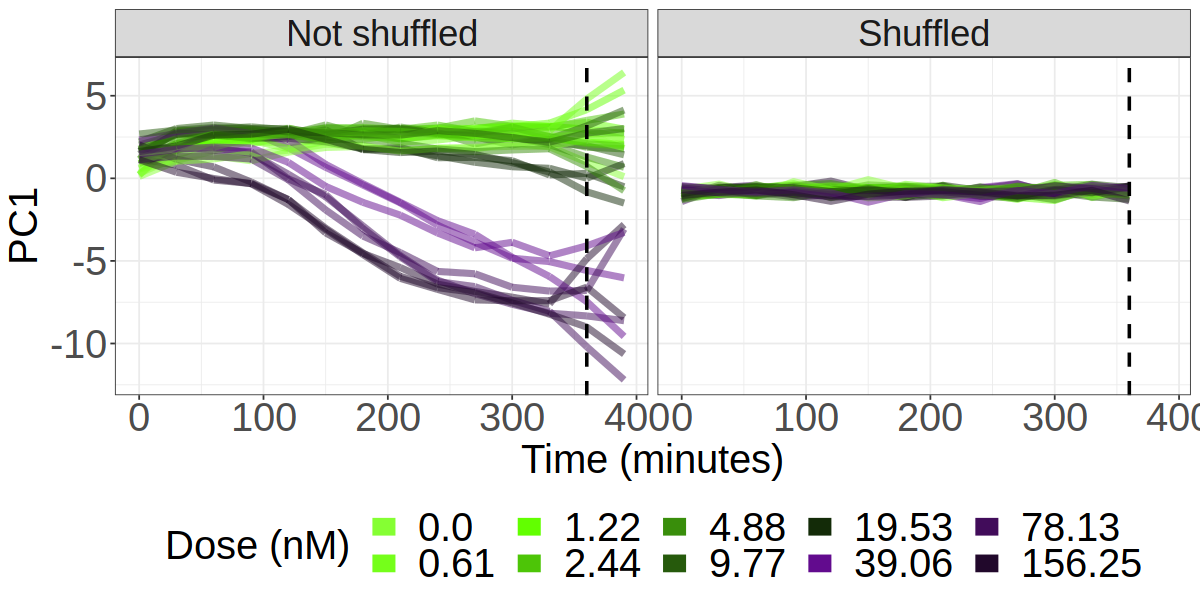

In [6]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca1_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC1, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_wrap(shuffled ~ .)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC1", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))
)
ggsave(
    filename = "../figures/predicted_PC1.png",
    plot = pca1_plot,
    width = width,
    height = height,
    dpi = 600
)
pca1_plot

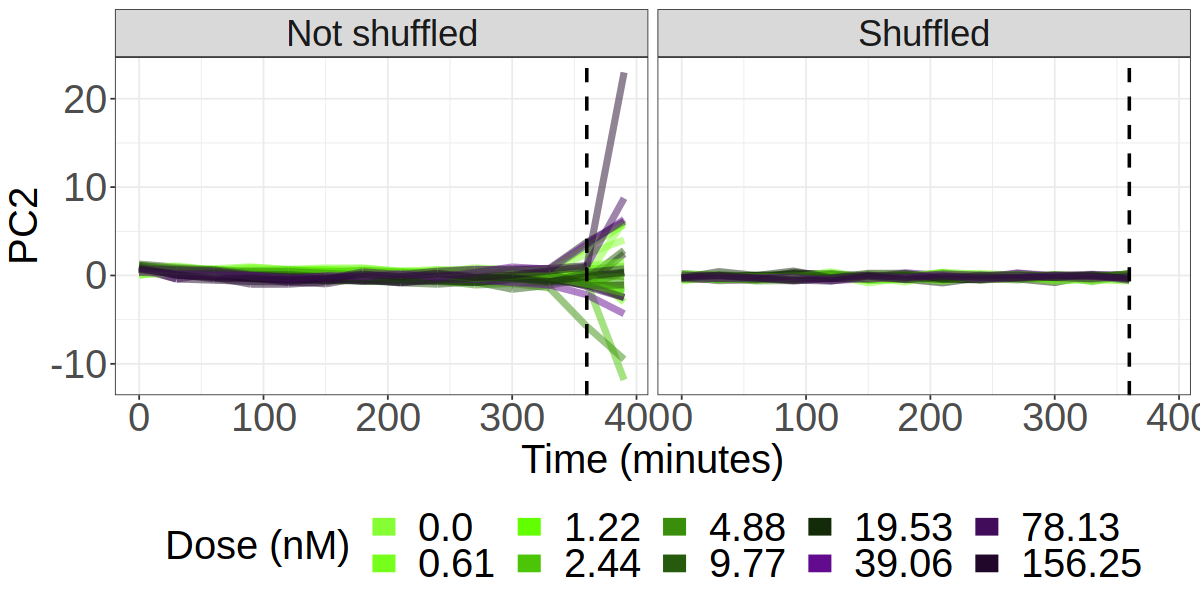

In [7]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca2_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC2, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_wrap(shuffled ~ .)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC2", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))
)
ggsave(
    filename = "../figures/predicted_PC2.png",
    plot = pca2_plot,
    width = width,
    height = height,
    dpi = 600
)
pca2_plot

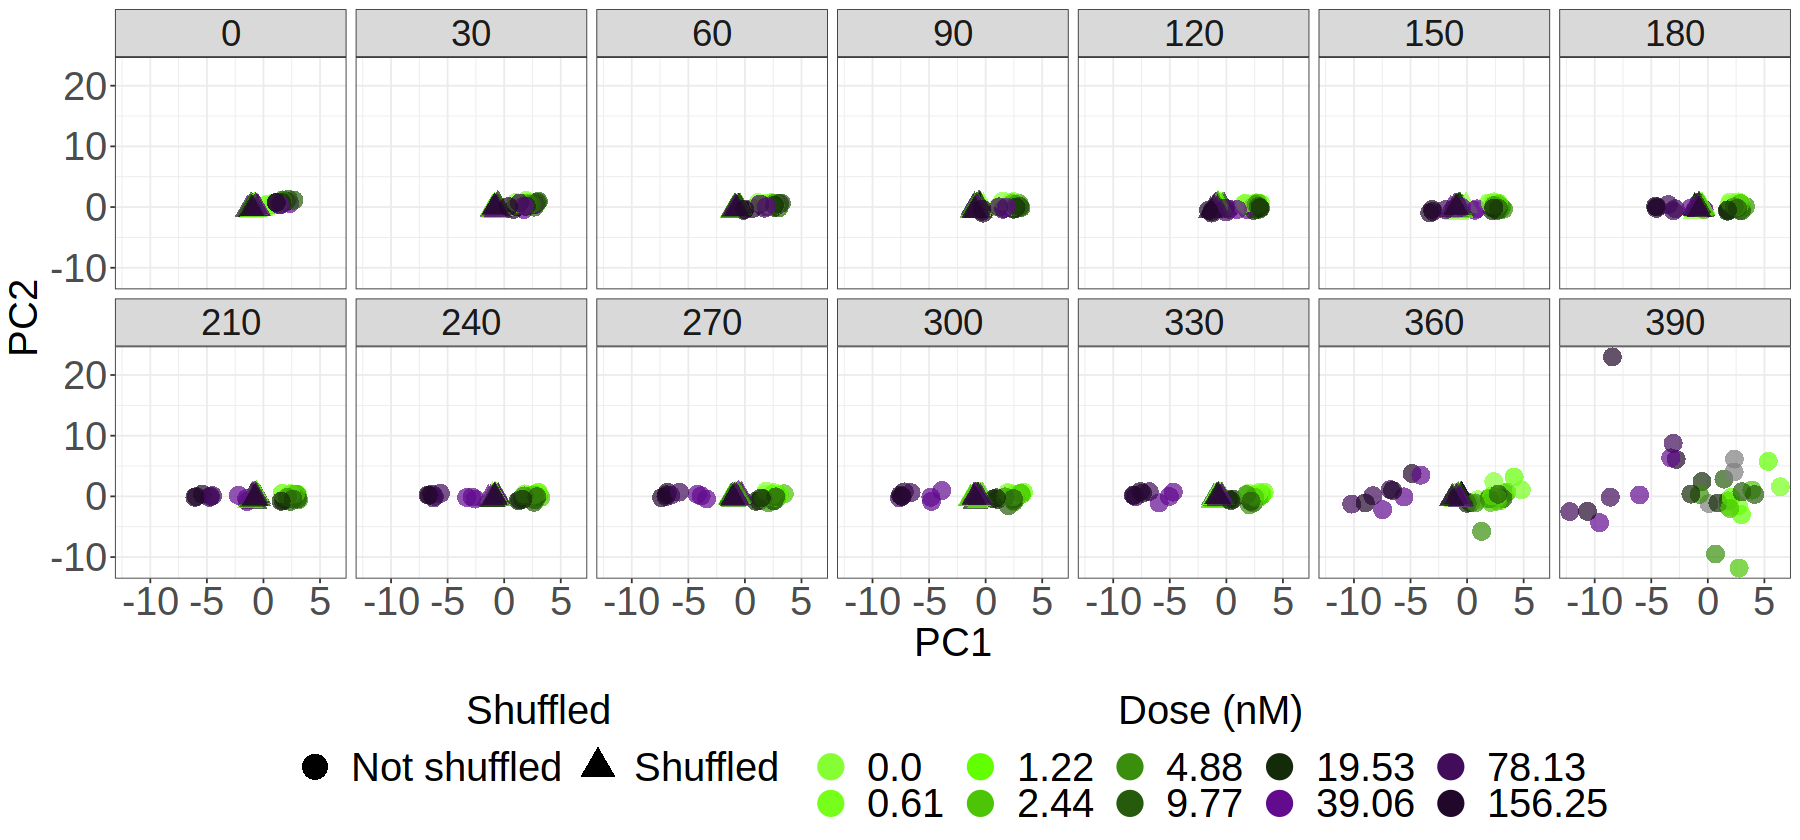

In [ ]:
# plot PCA1 vs PCA2 over time
width <- 15
height <- 7
options(repr.plot.width=width, repr.plot.height=height)
pca_over_time_plot <- (
    ggplot(pca_df, aes(x = PC1, y = PC2, color = Metadata_dose))
    + geom_point(aes(shape = shuffled), size = 5, alpha = 0.7)
    + theme_minimal() 
    + facet_wrap( ~ Metadata_Time, ncol = 7)
    + labs(x="PC1", y="PC2", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + scale_shape_manual(values = c(16, 17), name = "Shuffled")
    + guides(
        color = guide_legend(
            override.aes = list(size = 7, alpha = 1),
            title.position = "top",
            title.hjust = 0.5,
            ),
        shape = guide_legend(
            override.aes = list(size = 7, alpha = 1),
            title.position = "top",
            title.hjust = 0.5,
        )
    )

)
ggsave(
    filename = "../figures/pca_over_time.png",
    plot = pca_over_time_plot,
    width = width,
    height = height,
    dpi = 600
)
pca_over_time_plot

In [10]:

# merged_results$Metadata_dose <- gsub('0', '0.0', merged_results$Metadata_dose)
unique(merged_results$Metadata_dose)
merged_results <- merged_results %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
merged_results <- merged_results %>% arrange(Group)
head(merged_results)

[1] <NA>   0.61   1.22   2.44   4.88   9.77   19.53  39.06  78.13  156.25
[11] 0.0   
Levels: 0.0 0.61 1.22 2.44 4.88 9.77 19.53 39.06 78.13 156.25

Metadata_Well,Metadata_dose,Terminal_Intensity_LowerQuartileIntensity_AnnexinV,Terminal_Intensity_MADIntensity_AnnexinV,Terminal_Intensity_MADIntensity_DNA,Terminal_Intensity_MaxIntensity_AnnexinV,Terminal_Intensity_MaxIntensity_DNA,Terminal_Intensity_MeanIntensity_AnnexinV,Terminal_Intensity_MeanIntensity_DNA,Terminal_Intensity_StdIntensity_AnnexinV,Terminal_Intensity_StdIntensity_DNA,Terminal_Intensity_UpperQuartileIntensity_AnnexinV,Terminal_Intensity_UpperQuartileIntensity_DNA,Metadata_Time,shuffled,Group
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
C-02,0.0,0.03015051,-0.6363698,8.010986e-07,-0.4517316,0.09468088,0.54450303,0.5810192,0.2996676,1.1802845,-0.10099895,-0.4533981,0,Not shuffled,C-02
C-02,0.0,-0.13580561,-1.5290455,7.400626e-07,-0.5661693,0.41164585,0.78731265,0.6440394,0.4647077,2.3280900,0.05530353,-0.4119342,0,Shuffled,C-02
C-02,0.0,0.09999386,-0.4172084,5.493248e-07,-0.4189054,0.18087391,0.01000582,0.3560168,0.1538301,0.6642228,-0.30462446,-0.3226968,30,Not shuffled,C-02
C-02,0.0,-0.10411550,-1.6518614,6.332494e-07,-0.4846119,0.38285656,0.48411657,0.8156508,0.4402670,2.3901763,-0.14195157,-0.6147465,30,Shuffled,C-02
C-02,0.0,0.14961391,-0.3752011,5.798428e-07,-0.4156131,0.13100317,-0.03251243,0.3578602,-0.1025287,0.5547995,-0.45455654,-0.2226428,60,Not shuffled,C-02
C-02,0.0,-0.16707875,-1.9087553,7.629511e-07,-0.4872972,0.36715406,0.55125116,0.7296689,0.5539059,2.2676911,-0.13656706,-0.3776815,60,Shuffled,C-02


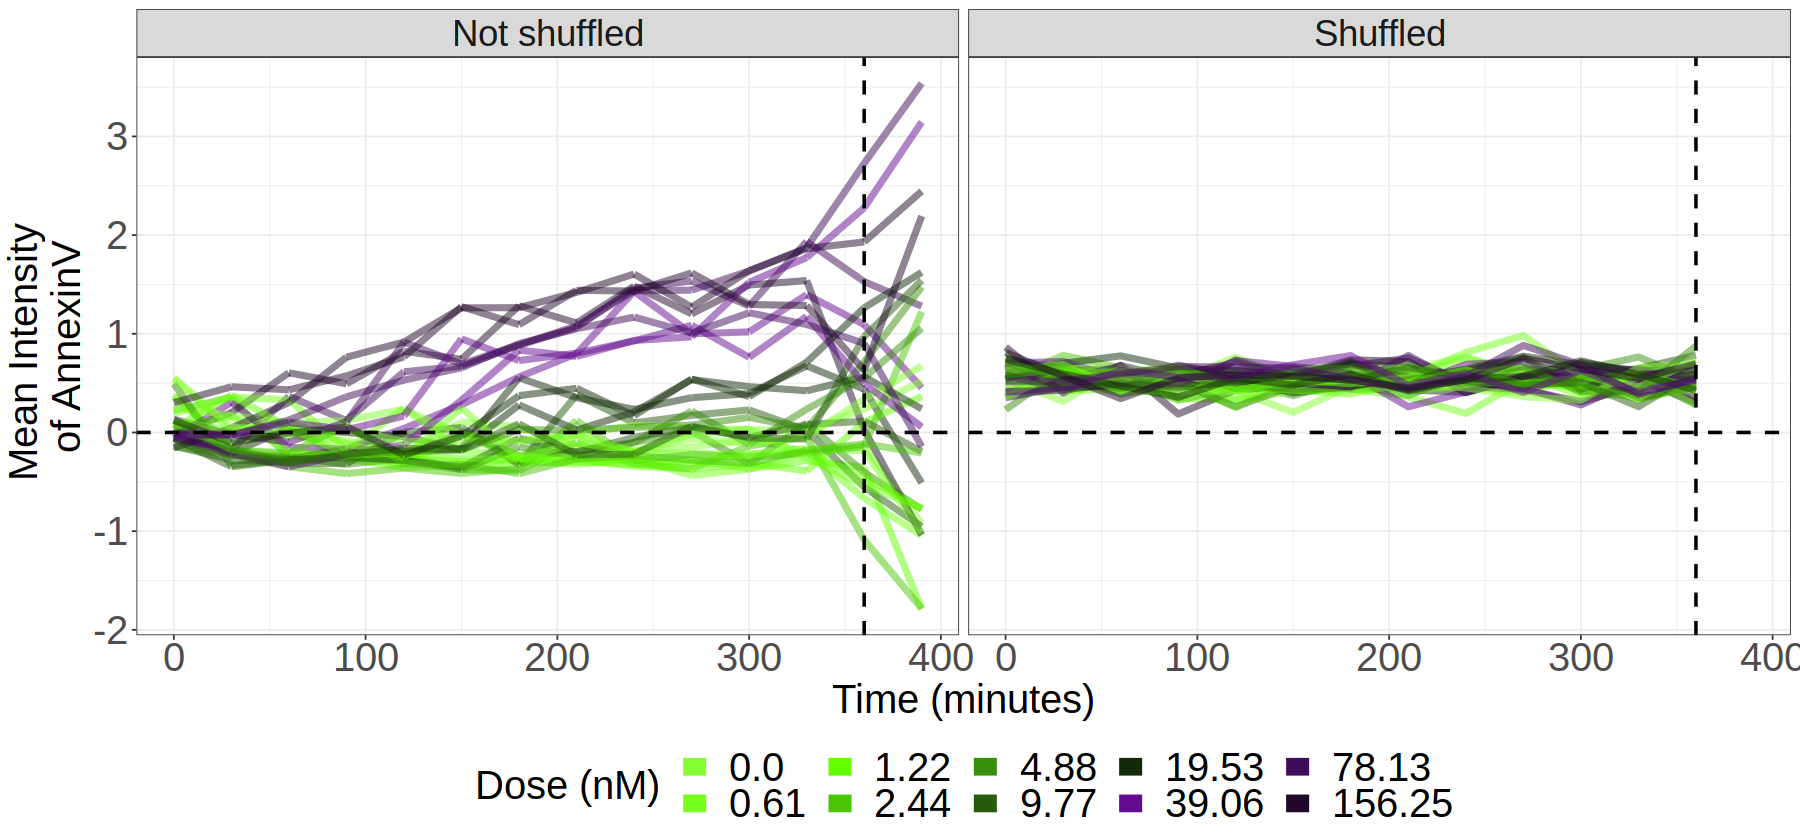

In [11]:
# plot the pca
feature_plot <- (
    ggplot(merged_results, aes(x = Metadata_Time, y = Terminal_Intensity_MeanIntensity_AnnexinV, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_wrap(shuffled ~ .)

    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 1)

    + labs(x="Time (minutes)", y="Mean Intensity \nof AnnexinV", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))


)
ggsave(
    filename = "../figures/predicted_Terminal_Intensity_MeanIntensity_AnnexinV.png",
    plot = feature_plot,
    width = width,
    height = height,
    dpi = 600
)
feature_plot